In [ ]:
import pandas
import torch
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
import numpy as np
import pandas as pd
import fasttext
import glob, os
from sklearn.metrics.pairwise import cosine_distances
from scipy.optimize import linear_sum_assignment

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the login token from environment variables
login_token = os.getenv('LOGIN_TOKEN')

# Check if the login token was loaded
if login_token is None:
    raise ValueError("Login token not found. Make sure you have set it in the .env file.")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
def load_embedding_model(model_name):
    if model_name == "llama3":
        # Load pre-trained LLaMA model and tokenizer
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
    elif model_name == "mistral":
        # Load pre-trained Mistral model and tokenizer
        model_loc = "mistralai/Mistral-7B-Instruct-v0.3"
        model = AutoModelForCausalLM.from_pretrained(model_loc)
        tokenizer = AutoTokenizer.from_pretrained(model_loc)
    elif model_name == "bert":
        # Load pre-trained BERT model and tokenizer
        model = AutoModel.from_pretrained("bert-base-uncased")
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    elif model_name == "roberta":
        # Load pre-trained BERT model and tokenizer
        model = AutoModel.from_pretrained("roberta-base")
        tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    elif model_name == "fasttext":
        # Load pre-trained fastText model
        model = fasttext.load_model("cc.en.300.bin")
        tokenizer = None  # fastText does not use a tokenizer
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    # Add a padding token if it does not exist and if the model uses a tokenizer
    if tokenizer is not None and tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))  # Resize model embeddings to accommodate new pad token

    return model, tokenizer

def get_each_cell_embeddings(texts, model_name, model, tokenizer):
    if model_name in {"llama3", "mistral", "bert", "roberta"}:
        # Tokenize the input texts with padding and truncation
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

        # Get the last hidden state
        with torch.no_grad():
            if model_name == "llama3":
                last_hidden_state = model.base_model(**inputs, output_hidden_states=True).last_hidden_state
            elif model_name == "mistral":
                last_hidden_state = model(**inputs, output_hidden_states=True).hidden_states[-1]
            elif model_name in {"bert", "roberta"}:
                last_hidden_state = model(**inputs, output_hidden_states=True).last_hidden_state
        # Mask the padding tokens
        attention_mask = inputs['attention_mask'].unsqueeze(-1)
        masked_last_hidden_state = last_hidden_state * attention_mask

        # Compute the average embedding for each sentence
        sum_embeddings = masked_last_hidden_state.sum(dim=1)
        count_non_pad_tokens = attention_mask.sum(dim=1)  # .unsqueeze(-1)
        # Avoid division by zero (if a sequence only contains padding tokens)
        count_non_pad_tokens = torch.clamp(count_non_pad_tokens, min=1)
        average_embeddings = sum_embeddings / count_non_pad_tokens

        # Convert to numpy for use with scikit-learn
        average_embeddings_np = average_embeddings.detach().numpy()
    
    elif model_name == "fasttext":
        average_embeddings_np = []
        for text in texts:
            tokens = text.split()  # Assuming the tokenizer is a simple space split
            word_embeddings = [model.get_word_vector(token) for token in tokens]
            if word_embeddings:
                average_embedding = np.mean(word_embeddings, axis=0)
            else:
                average_embedding = np.zeros(model.get_dimension())  # Handle empty text case
            average_embeddings_np.append(average_embedding)
        average_embeddings_np = np.array(average_embeddings_np)

    return average_embeddings_np

In [ ]:
def apply_bipartite_matching(average_embeddings_1, average_embeddings_2, texts1, texts2, threshold=0.5, penalty=5.0):
    """
    Apply bipartite matching with quality enhancement, allowing some texts to remain unmatched.

    Parameters:
    average_embeddings_1 (list or numpy array): Embeddings for the first set of texts.
    average_embeddings_2 (list or numpy array): Embeddings for the second set of texts.
    texts1 (list): List of texts corresponding to average_embeddings_1.
    texts2 (list): List of texts corresponding to average_embeddings_2.
    threshold (float): Cosine distance threshold for filtering matches.
    penalty (float): High penalty cost for matching a text to a dummy.

    Returns:
    matching_results (list of tuples): Optimal matches as (text1, text2, distance) tuples.
    combined_embeddings (list): Combined embeddings of the matched pairs and unmatched embeddings.
    unmatched_texts1 (set): Set of unmatched texts from the first list.
    unmatched_texts2 (set): Set of unmatched texts from the second list.
    """
    num_texts1 = len(average_embeddings_1)
    num_texts2 = len(average_embeddings_2)

    # Compute cosine distance matrix
    cosine_distance_matrix = cosine_distances(average_embeddings_1, average_embeddings_2)

    # Augment the cosine distance matrix to allow for unmatched texts
    augmented_size = num_texts1 + num_texts2
    augmented_cosine_matrix = np.full((augmented_size, augmented_size), penalty)
    augmented_cosine_matrix[:num_texts1, :num_texts2] = cosine_distance_matrix

    # Apply Hungarian algorithm on the augmented matrix
    row_indices, col_indices = linear_sum_assignment(augmented_cosine_matrix)

    # Filter matches based on the threshold
    matching_results = []
    combined_embeddings = []
    matched_texts1 = set()
    matched_texts2 = set()

    for row, col in zip(row_indices, col_indices):
        if row < num_texts1 and col < num_texts2 and augmented_cosine_matrix[row, col] < threshold:
            matching_results.append((texts1[row], texts2[col], augmented_cosine_matrix[row, col]))
            combined_embedding = (average_embeddings_1[row] + average_embeddings_2[col]) / 2
            combined_embeddings.append(combined_embedding)
            matched_texts1.add(texts1[row])
            matched_texts2.add(texts2[col])

    # Add unmatched embeddings
    unmatched_texts1 = set(texts1) - matched_texts1
    unmatched_texts2 = set(texts2) - matched_texts2

    unmatched_indices1 = [texts1.index(text) for text in unmatched_texts1]
    unmatched_indices2 = [texts2.index(text) for text in unmatched_texts2]

    for idx in unmatched_indices1:
        combined_embeddings.append(average_embeddings_1[idx])

    for idx in unmatched_indices2:
        combined_embeddings.append(average_embeddings_2[idx])

    return matching_results, combined_embeddings, unmatched_texts1, unmatched_texts2

def apply_bipartite_matching_simple(average_embeddings_1, average_embeddings_2, texts1, texts2, threshold=0.5):
    # Compute cosine distance matrix using scikit-learn
    cosine_distance_matrix = cosine_distances(average_embeddings_1, average_embeddings_2)
    # Apply Hungarian algorithm to find the optimal bipartite matching
    row_indices, col_indices = linear_sum_assignment(cosine_distance_matrix)

    # Filter matches based on the threshold
    matching_results = []
    combined_embeddings = []
    for row, col in zip(row_indices, col_indices):
        if cosine_distance_matrix[row, col] < threshold:
            matching_results.append((texts1[row], texts2[col], cosine_distance_matrix[row, col]))
            combined_embedding = (average_embeddings_1[row] + average_embeddings_2[col]) / 2
            combined_embeddings.append(combined_embedding)
    
    # Add unmatched embeddings
    unmatched_texts1 = set(texts1) - {pair[0] for pair in matching_results}
    unmatched_texts2 = set(texts2) - {pair[1] for pair in matching_results}

    unmatched_indices1 = [texts1.index(text) for text in unmatched_texts1]
    unmatched_indices2 = [texts2.index(text) for text in unmatched_texts2]

    for idx in unmatched_indices1:
        combined_embeddings.append(average_embeddings_1[idx])

    for idx in unmatched_indices2:
        combined_embeddings.append(average_embeddings_2[idx])
    return matching_results, combined_embeddings, unmatched_texts1, unmatched_texts2

In [ ]:
model_name = "mistral"
model, tokenizer = load_embedding_model(model_name)

In [ ]:
benchmark_name = r"autojoin_pairs"

benchmark_integration_sets = glob.glob(r"benchmark"+ os.sep + benchmark_name + os.sep + "*")

In [ ]:
def get_value_pairs(source_col, target_col, groundtruth):
   
    # Determine possible column names in the ground truth DataFrame
    possible_gt_source_cols = [source_col, f'source-{source_col}']
    possible_gt_target_cols = [target_col, f'target-{target_col}']
    # print("source col: ", source_col)
    # print("target col: ", target_col)
    # Find the actual columns in the ground truth DataFrame
    gt_source_col = next((col for col in possible_gt_source_cols if col in groundtruth.columns), None)
    gt_target_col = next((col for col in possible_gt_target_cols if col in groundtruth.columns), None)
    # print(gt_source_col)
    # print(gt_target_col)
    if gt_source_col is None or gt_target_col is None:
        raise ValueError("Matching columns not found in ground truth DataFrame")

    # Extract the relevant columns from the ground truth DataFrame
    source_column_in_gt = groundtruth[gt_source_col]
    target_column_in_gt = groundtruth[gt_target_col]

    # Zip these columns together to create tuples
    value_pairs = zip(source_column_in_gt, target_column_in_gt)

    # Convert these tuples to a set to ensure uniqueness
    value_pairs_set = set(value_pairs)
    value_pairs_set= {tuple(sorted(pair)) for pair in value_pairs_set}
    return value_pairs_set

In [ ]:
# texts1_list = ["Berlinn", "Toronto", "Barcelona"]
# texts2_list = ["Toronto", "Boston", "Berlin", "Barcelona"]
# texts3_list = ["Berlin", "barcelna", "Boston"]
all_precision = []
all_recall = []
all_f_score = []
for integration_set in benchmark_integration_sets:
    # print("Int set:", integration_set)
    source_table = pd.read_csv(integration_set + os.sep + "source.csv")
    target_table = pd.read_csv(integration_set + os.sep + "target.csv")
    gt_table = pd.read_csv(integration_set + os.sep + "ground truth.csv")
    # print(source_table)
    # print(source_table.columns)
    source_column_name = source_table.columns[0]
    source_column_values = list(source_table[source_table.columns[0]])
    target_column_name = target_table.columns[0]
    target_column_values = list(target_table[target_table.columns[0]])
    gt_matches = get_value_pairs(source_column_name, target_column_name, gt_table)
    all_columns = [source_column_values, target_column_values]
    value_frequency = {}
    for column in all_columns:
        for value in column:
            if value in value_frequency:
                value_frequency[value] += 1
            else:
                value_frequency[value] = 1
    all_matching_results = set()
    first_column = all_columns.pop(0)
    for second_column in all_columns:
        texts1 = list(set(first_column))
        texts2 = list(set(second_column))
        average_embeddings_1 = get_each_cell_embeddings(texts1, model_name, model, tokenizer)
        average_embeddings_2 = get_each_cell_embeddings(texts2, model_name, model, tokenizer)

        matching_results, combined_embeddings, unmatched_texts1, unmatched_texts2 = apply_bipartite_matching_simple(average_embeddings_1, average_embeddings_2, texts1, texts2, threshold = 1)
        for each in matching_results:
            all_matching_results.add(tuple(sorted((each[0], each[1]))))
        
        # # Print the matching results with their scores
        # print("Optimal Bipartite Matching with Scores:")
        # for pair in matching_results:
        #     print(f"{pair[0]} -> {pair[1]} with score: {pair[2]}")


        # # Print unmatched texts
        # print("\nUnmatched Texts from texts1:")
        # for text in unmatched_texts1:
        #     print(text)

        # print("\nUnmatched Texts from texts2:")
        # for text in unmatched_texts2:
        #     print(text)
    precision = len(all_matching_results.intersection(gt_matches))/len(all_matching_results)
    recall = len(all_matching_results.intersection(gt_matches))/len(gt_matches)
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

In [ ]:
print("Model name: ", model_name)
print("Average Precision: ", sum(all_precision)/len(all_precision))
print("Average Recall: ", sum(all_recall)/ len(all_recall))
print("Average f1:", sum(all_f1) / len(all_f1))

In [ ]:
# import hnswlib
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # Function to index embeddings using HNSW index
# def index_embeddings_hnsw(embeddings, ef_construction = 200, M= 16, number_of_neighbors = 50):
#     # Initialize HNSW index
#     dim = embeddings.shape[1]  # Get the dimension of embeddings
#     num_elements = embeddings.shape[0]  # Get the number of embeddings
#     p = hnswlib.Index(space='cosine', dim=dim)
#     p.init_index(max_elements=num_elements, ef_construction=ef_construction, M=M)
#     number_of_neighbors = num_elements
#     p.set_ef(number_of_neighbors)  # Set the number of neighbors to search during the query

#     # Add embeddings to HNSW index
#     p.add_items(embeddings)

#     return p

# # Function to find embeddings within threshold distance from a query embedding using HNSW index
# def find_embeddings_within_threshold_hnsw(query_embedding, hnsw_index, k, embeddings, threshold):  # Pass embeddings as argument
#     # Query HNSW index for candidate nearest neighbors
#     labels, distances = hnsw_index.knn_query(query_embedding, k=k)    
#     # Filter candidate indices based on cosine similarity threshold
#     print(labels)
#     print(distances)
    
#     # Filter candidate indices based on cosine distance threshold
#     indices_within_threshold = []
#     for i in range(0, len(labels)):
#         for label, distance in zip(labels[i], distances[i]):
#             if distance > threshold:
#                 break
#             indices_within_threshold.append((label, distance))
#         # indices_within_threshold = [(label, distance) for label, distance in zip(labels[0], distances[0]) if distance <= threshold]

#     return indices_within_threshold

# # Example threshold value
# threshold = 0.1

# # Example query embedding (replace this with your actual query embedding)
# # query_embedding = average_embeddings_np[2]
# # Generate random embeddings of size (8, 4096) with dtype=np.float32
# average_embeddings_np = np.random.rand(10000, 4096).astype(np.float32)
# query_embedding =  average_embeddings_np # Generating a random query embedding of size (4096,) with dtype=np.float32

# # Index embeddings using HNSW index
# hnsw_index = index_embeddings_hnsw(average_embeddings_np)
# k = hnsw_index.max_elements
# k =20 
# # Find embeddings within threshold distance from the query embedding using HNSW index
# indices_within_threshold = find_embeddings_within_threshold_hnsw(query_embedding, hnsw_index,k, average_embeddings_np, threshold)  # Pass embeddings
# # Print indices of embeddings within threshold distance
# print("Indices of embeddings within threshold distance:", indices_within_threshold)


In [ ]:
import pandas as pd
import os

def load_csv_files(folder_path):
    """
    Load CSV files from a folder into a dictionary of DataFrames.
    """
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            table_name = os.path.splitext(filename)[0]
            file_path = os.path.join(folder_path, filename)
            data[table_name] = pd.read_csv(file_path)
    return data

def create_column_dictionary(data):
    """
    Create a dictionary with column headers as keys and lists of column values as values.
    """
    column_dict = {}
    for table_name, df in data.items():
        for column in df.columns:
            if column not in column_dict:
                column_dict[column] = []
            column_dict[column].append(df[column].tolist())
    return column_dict

# Path to the folder containing CSV files
folder_path = "benchmark/imdb Benchmark samples/sample1"

# Load CSV files into a dictionary of DataFrames
data = load_csv_files(folder_path)

# Create a dictionary with column headers as keys and lists of column values as values
column_dictionary = create_column_dictionary(data)

# # Print the dictionary
# for column, values in column_dictionary.items():
#     print(f"{column}: {values}")


In [32]:
import pandas as pd

imdb_time = pd.read_csv(r"/home/khatiwada/alite/statistics/integration_time_imdb_benchmark.csv")

In [33]:
imdb_time

,integration set,n,S,F,F_S_ratio,total_cols,biconnected_components,subsumed_tuples,ALITE,BICOMNLOJ,ParaFD
0,sample0,6,0,0,0.000000,28,2,0,0.000000,0.000000,0.000000
1,sample1,6,2552,24616,9.645768,28,2,0,56.204200,66.512518,20.237819
2,sample2,6,7710,279710,36.278859,28,2,0,408.595761,684.071198,316.979939
3,sample3,6,12735,549099,43.117314,28,2,0,923.294596,2003.956517,712.143748
4,sample4,6,17362,1026127,59.101889,28,2,0,1833.706116,4028.927787,1447.032456
5,sample5,6,22186,1681705,75.800279,28,2,0,3081.879069,6489.245946,2562.220670
6,sample6,6,29806,2478921,83.168523,28,2,0,4367.110028,9061.100237,3968.004924


In [34]:
new_column = [0, 8.15, 9.14, 19.66, 31.57, 52.63, 80.33]
imdb_time["Fuzzy FD"] = imdb_time["ALITE"] + new_column

In [35]:
imdb_time

,integration set,n,S,F,F_S_ratio,total_cols,biconnected_components,subsumed_tuples,ALITE,BICOMNLOJ,ParaFD,Fuzzy FD
0,sample0,6,0,0,0.000000,28,2,0,0.000000,0.000000,0.000000,0.000000
1,sample1,6,2552,24616,9.645768,28,2,0,56.204200,66.512518,20.237819,64.354200
2,sample2,6,7710,279710,36.278859,28,2,0,408.595761,684.071198,316.979939,417.735761
3,sample3,6,12735,549099,43.117314,28,2,0,923.294596,2003.956517,712.143748,942.954596
4,sample4,6,17362,1026127,59.101889,28,2,0,1833.706116,4028.927787,1447.032456,1865.276116
5,sample5,6,22186,1681705,75.800279,28,2,0,3081.879069,6489.245946,2562.220670,3134.509069
6,sample6,6,29806,2478921,83.168523,28,2,0,4367.110028,9061.100237,3968.004924,4447.440028


In [36]:
imdb_time.to_csv(r"logs/imdb_benchmark_time.csv", index = False)

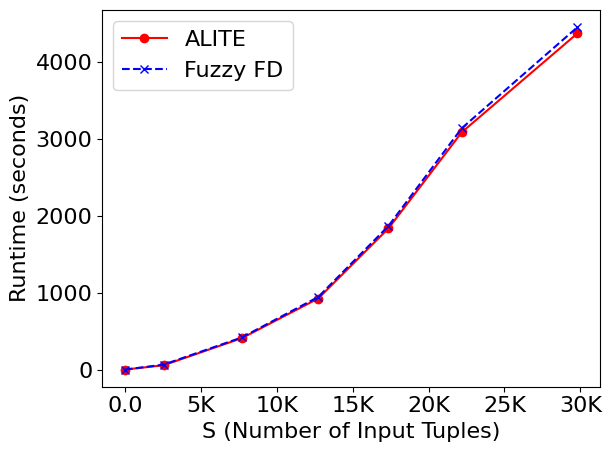

In [52]:
# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# plt.figure(figsize=(10, 6))
plt.plot(imdb_time['S'], imdb_time['ALITE'], marker='o', linestyle = '-', color='red', label='ALITE')
plt.plot(imdb_time['S'], imdb_time['Fuzzy FD'], marker='x', color='blue', linestyle='--', label='Fuzzy FD')

# Adding labels and title
plt.xlabel('S (Number of Input Tuples)')
plt.ylabel('Runtime (seconds)')
plt.rcParams.update({'font.size': 16})
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}K'.format(x / 1000) if x >= 1000 else '{:.1f}'.format(x)))
plt.tight_layout()

# plt.title('Runtime Comparison of regular FD (ALITE) and Fuzzy FD')
plt.legend()
plt.savefig('runtime_comparison.pdf')

# Display the plot
plt.show()

In [2]:
import os
import pandas as pd

# Define the paths to the folders
clean_folder = r'benchmark/stadiums_final_clean'
dirty_folder = r'benchmark/stadiums_final_dirty'
output_folder = r'benchmark/stadiums_final_output'

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get the list of CSV files in the clean folder
clean_files = [f for f in os.listdir(clean_folder) if f.endswith('.csv')]

# Iterate through each file in the clean folder
for file_name in clean_files:
    clean_file_path = os.path.join(clean_folder, file_name)
    dirty_file_path = os.path.join(dirty_folder, file_name)
    
    if os.path.exists(dirty_file_path):
        # Load the dataframes
        dataframe1 = pd.read_csv(clean_file_path)
        dataframe2 = pd.read_csv(dirty_file_path)
        
        # Find rows that exist only in dataframe2
        diff_df = dataframe2.merge(dataframe1, on=list(dataframe1.columns), how='left', indicator=True)
        diff_df = diff_df[diff_df['_merge'] == 'left_only'].drop(columns=['_merge'])
        
        # Save the resulting dataframe to a CSV file in the output folder
        output_file_path = os.path.join(output_folder, file_name)
        diff_df.to_csv(output_file_path, index=False)
        
        print(f"Processed {file_name}: {len(diff_df)} unique rows saved to {output_file_path}")
    else:
        print(f"Skipping {file_name}: No corresponding file in dirty folder.")


Processed stadiums_0.csv: 27 unique rows saved to benchmark/stadiums_final_output/stadiums_0.csv
Processed stadiums_1.csv: 25 unique rows saved to benchmark/stadiums_final_output/stadiums_1.csv
Processed stadiums_2.csv: 7 unique rows saved to benchmark/stadiums_final_output/stadiums_2.csv
Processed stadiums_3.csv: 2 unique rows saved to benchmark/stadiums_final_output/stadiums_3.csv
